# Composite Operator Demo
Quantum algorithms typically contain a subroutine that involves running a quantum circuit, which are constructed using quantum gates. However, often we are not necessarily interested in knowing precisely what gates compose the algorithm's circuit and are only interested in the high level design. For example, in the below circuit for Quantum Phase Estimation, a group of gates has been summarized as a block corresponding to the inverse Quantum Fourier Transform. This also helps improve clarity in a circuit's design when visualizing. In general, the composite operator feature lets us do circuit construction at higher levels of abstraction. This notebook focuses on demonstrating some example usages.
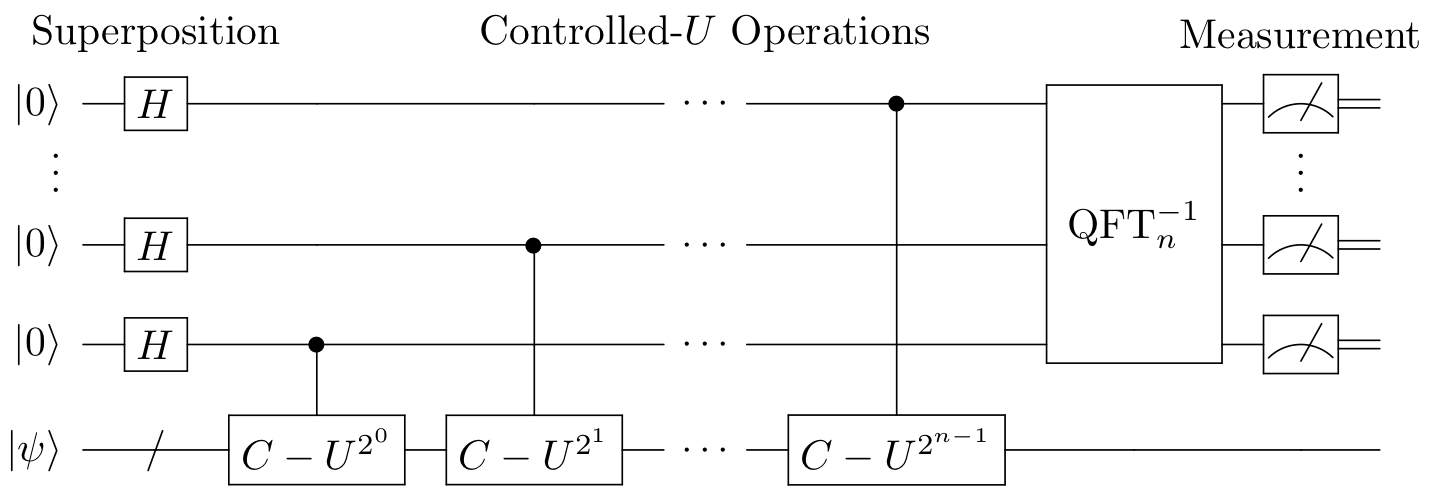

## IMPORTS and SETUP

In [1]:
# general imports
import numpy as np
import math

# AWS imports: Import Amazon Braket SDK modules
from braket.circuits import Circuit, circuit
from braket.circuits.composite_operators import *

# Composite Operator Definition
A composite operator is defined to be a composition of quantum operators (i.e. gates or other composite operators), and it can accept a variable number of target qubits. To give a simple demonstration of how they work, first, here is how one would normally construct the circuit that prepares the Greenberger-Horne-Zeilinger (GHZ) state with gates:

In [2]:
def ghz(qubits):
    ghzcirc = Circuit().h(qubits[0])
    for i in range(0, len(qubits) - 1):
        ghzcirc.cnot(qubits[i], qubits[i + 1])
    return ghzcirc

In [3]:
qubits = [0, 1, 2, 3]
print(ghz(qubits))

T  : |0|1|2|3|
              
q0 : -H-C-----
        |     
q1 : ---X-C---
          |   
q2 : -----X-C-
            | 
q3 : -------X-

T  : |0|1|2|3|


However, a composite operator corresponding to the construction of the GHZ state has already been implemented in the composite_operators module. Thus, we can construct the same circuit with one line of code by calling its corresponding circuit subroutine as shown below. The printed circuit groups all the gates into a GHZ block, with asterisks denoting the target qubits. We can decompose it to verify that it indeed corresponds to the same circuit as above.

In [4]:
# Call the GHZ circuit subroutine
ghzcirc = Circuit().ghz(qubits)

print('GHZ operator:')
print(ghzcirc)
print('Decomposed GHZ circuit:')
print(ghzcirc.decompose())

GHZ operator:
T  : | 0 |
          
q0 : -GHZ-
      | | 
q1 : -|*|-
      | | 
q2 : -|*|-
      | | 
q3 : -|*|-

T  : | 0 |
Decomposed GHZ circuit:
T  : |0|1|2|3|
              
q0 : -H-C-----
        |     
q1 : ---X-C---
          |   
q2 : -----X-C-
            | 
q3 : -------X-

T  : |0|1|2|3|


# Composing a composite operators with other operators
Below is the implementation of the Quantum Fourier Transform given in the Amazon Braket tutorials repository (https://github.com/aws/amazon-braket-examples/blob/main/examples/advanced_circuits_algorithms/QFT/QFT.ipynb).

In [5]:
def qft(qubits):    
    """
    Construct a circuit object corresponding to the Quantum Fourier Transform (QFT)
    algorithm, applied to the argument qubits.  Does not use recursion to generate the QFT.
    
    Args:
        qubits (int): The list of qubits on which to apply the QFT
    """
    qftcirc = Circuit()
    
    # get number of qubits
    num_qubits = len(qubits)
    
    for k in range(num_qubits):
        # First add a Hadamard gate
        qftcirc.h(qubits[k])
    
        # Then apply the controlled rotations, with weights (angles) defined by the distance to the control qubit.
        # Start on the qubit after qubit k, and iterate until the end.  When num_qubits==1, this loop does not run.
        for j in range(1,num_qubits - k):
            angle = 2*math.pi/(2**(j+1))
            qftcirc.cphaseshift(qubits[k+j],qubits[k], angle)
            
    # Then add SWAP gates to reverse the order of the qubits:
    for i in range(math.floor(num_qubits/2)):
        qftcirc.swap(qubits[i], qubits[-i-1])
        
    return qftcirc

Here, we construct a circuit consisting of a hadamard gate and the gates corresponding to the QFT circuit. However, it isn't very easy to distnguish the QFT process from the other operator in the resulting diagram.

In [6]:
qubits = [0, 1, 2, 3]
qftcirc = Circuit().h(1)
qftcirc.add(qft(qubits))
print(qftcirc)

T  : |0|     1     |      2       |           3            |      4       |     5     | 6  | 7  |
                                                                                                 
q0 : -H-PHASE(1.57)-PHASE(0.785)---PHASE(0.393)---------------------------------------------SWAP-
        |           |              |                                                        |    
q1 : -H-C-----------|------------H-|------------PHASE(1.57)-PHASE(0.785)---------------SWAP-|----
                    |              |            |           |                          |    |    
q2 : ---------------C--------------|------------C-----------|------------H-PHASE(1.57)-SWAP-|----
                                   |                        |              |                |    
q3 : ------------------------------C------------------------C--------------C-----------H----SWAP-

T  : |0|     1     |      2       |           3            |      4       |     5     | 6  | 7  |


If we instead add QFT as a composite operator rather than a series of gates and print the circuit, we see that the circuit diagram gets compartmentalized, making it easier to distinguish the QFT part from the extra hadamard gate. Calling `decompose` on this circuit shows that it is the same as the above circuit.

In [7]:
qftcirc = Circuit().h(1).qft(qubits)
print('QFT operator and hadamard:')
print(qftcirc)
print('Decomposed circuit:')
print(qftcirc.decompose())

QFT operator and hadamard:
T  : |0| 1 |
            
q0 : ---QFT-
        | | 
q1 : -H-|*|-
        | | 
q2 : ---|*|-
        | | 
q3 : ---|*|-

T  : |0| 1 |
Decomposed circuit:
T  : |0|     1     |      2       |           3            |      4       |     5     | 6  | 7  |
                                                                                                 
q0 : -H-PHASE(1.57)-PHASE(0.785)---PHASE(0.393)---------------------------------------------SWAP-
        |           |              |                                                        |    
q1 : -H-C-----------|------------H-|------------PHASE(1.57)-PHASE(0.785)---------------SWAP-|----
                    |              |            |           |                          |    |    
q2 : ---------------C--------------|------------C-----------|------------H-PHASE(1.57)-SWAP-|----
                                   |                        |              |                |    
q3 : ------------------------------C--

We can also take things a step further and put multiple quantum algorithms in the same circuit. The decompose method decomposes all composite operators in the circuit.

In [8]:
qft_ghz_circ = Circuit().ghz(qubits[:-1]).qft(qubits)
print('QFT and GHZ operators:')
print(qft_ghz_circ)
print('Decomposed circuit:')
print(qft_ghz_circ.decompose())

QFT and GHZ operators:
T  : | 0 | 1 |
              
q0 : -GHZ-QFT-
      | | | | 
q1 : -|*|-|*|-
      | | | | 
q2 : -|*|-|*|-
          | | 
q3 : -----|*|-

T  : | 0 | 1 |
Decomposed circuit:
T  : |0|1|2|     3     |      4       |           5            |      6       |     7     | 8  | 9  |
                                                                                                     
q0 : -H-C-H-PHASE(1.57)-PHASE(0.785)---PHASE(0.393)---------------------------------------------SWAP-
        |   |           |              |                                                        |    
q1 : ---X-C-C-----------|------------H-|------------PHASE(1.57)-PHASE(0.785)---------------SWAP-|----
          |             |              |            |           |                          |    |    
q2 : -----X-------------C--------------|------------C-----------|------------H-PHASE(1.57)-SWAP-|----
                                       |                        |              |            

# Multiple levels of decomposition
Below is the implementation of the Quantum Phase Estimation given in the Amazon Braket tutorials repository (https://github.com/aws/amazon-braket-examples/blob/main/examples/advanced_circuits_algorithms/QPE/QPE.ipynb). The advantage of using the composite operator feature over constructing the circuit from gates is most apparent in this example.

In [9]:
# Define Pauli matrices
Id = np.eye(2)             # Identity matrix
X = np.array([[0., 1.],
              [1., 0.]])   # Pauli X
Y = np.array([[0., -1.j],
              [1.j, 0.]])  # Pauli Y
Z = np.array([[1., 0.],
              [0., -1.]])  # Pauli Z

In [10]:
def inverse_qft(qubits):
    """
    Construct a circuit object corresponding to the inverse Quantum Fourier Transform (QFT)
    algorithm, applied to the argument qubits.  Does not use recursion to generate the circuit.
    
    Args:
        qubits (int): The list of qubits on which to apply the inverse QFT
    """
    # instantiate circuit object
    qftcirc = Circuit()
    
    # get number of qubits
    num_qubits = len(qubits)
    
    # First add SWAP gates to reverse the order of the qubits:
    for i in range(math.floor(num_qubits/2)):
        qftcirc.swap(qubits[i], qubits[-i-1])
        
    # Start on the last qubit and work to the first.
    for k in reversed(range(num_qubits)):
    
        # Apply the controlled rotations, with weights (angles) defined by the distance to the control qubit.
        # These angles are the negative of the angle used in the QFT.
        # Start on the last qubit and iterate until the qubit after k.  
        # When num_qubits==1, this loop does not run.
        for j in reversed(range(1, num_qubits - k)):
            angle = -2*math.pi/(2**(j+1))
            qftcirc.cphaseshift(qubits[k+j],qubits[k], angle)
            
        # Then add a Hadamard gate
        qftcirc.h(qubits[k])
    
    return qftcirc

In [11]:
def controlled_unitary(control, target_qubits, unitary):
    """
    Construct a circuit object corresponding to the controlled unitary

    Args:
        control: The qubit on which to control the gate

        target_qubits: List of qubits on which the unitary U acts

        unitary: matrix representation of the unitary we wish to implement in a controlled way
    """

    # Define projectors onto the computational basis
    p0 = np.array([[1., 0.],
                   [0., 0.]])

    p1 = np.array([[0., 0.],
                   [0., 1.]])

    # Instantiate circuit object
    circ = Circuit()

    # Construct numpy matrix
    id_matrix = np.eye(len(unitary))
    controlled_matrix = np.kron(p0, id_matrix) + np.kron(p1, unitary)

    # Set all target qubits
    targets = [control] + target_qubits

    # Add controlled unitary
    circ.unitary(matrix=controlled_matrix, targets=targets)

    return circ

In [12]:
def qpe(precision_qubits, query_qubits, unitary, control_unitary=True):
    """
    Function to implement the QPE algorithm using two registers for precision (read-out) and query.
    Register qubits need not be contiguous.

    Args:
        precision_qubits: list of qubits defining the precision register

        query_qubits: list of qubits defining the query register

        unitary: Matrix representation of the unitary whose eigenvalues we wish to estimate

        control_unitary: Optional boolean flag for controlled unitaries,
                         with C-(U^{2^k}) by default (default is True),
                         or C-U controlled-unitary (2**power) times
    """
    qpe_circ = Circuit()

    # Get number of qubits
    num_precision_qubits = len(precision_qubits)
    num_query_qubits = len(query_qubits)

    # Apply Hadamard across precision register
    qpe_circ.h(precision_qubits)

    # Apply controlled unitaries. Start with the last precision_qubit, and end with the first
    for ii, qubit in enumerate(reversed(precision_qubits)):
        # Set power exponent for unitary
        power = ii

        # Alterantive 1: Implement C-(U^{2^k})
        if control_unitary:
            # Define the matrix U^{2^k}
            Uexp = np.linalg.matrix_power(unitary,2**power)

            # Apply the controlled unitary C-(U^{2^k})
            qpe_circ.add_circuit(controlled_unitary(qubit, query_qubits, Uexp))
        # Alterantive 2: One can instead apply controlled-unitary (2**power) times to get C-U^{2^power}
        else:
            for _ in range(2**power):
                qpe_circ.add_circuit(controlled_unitary(qubit, query_qubits, unitary))

    # Apply inverse qft to the precision_qubits
    qpe_circ.add_circuit(inverse_qft(precision_qubits))

    return qpe_circ

In [13]:
# set total number of qubits
precision_qubits = [0, 1, 2, 3]
query_qubits = [4]

# prepare query register
my_qpe_circ = Circuit()

# set unitary
unitary = X

# show small QPE example circuit
my_qpe_circ = qpe(precision_qubits, query_qubits, unitary)
print('QPE CIRCUIT:')
print(my_qpe_circ)

QPE CIRCUIT:
T  : |0|1|2|3|  4   | 5  |6|     7      |       8       |            9             |      10       |     11     |12|
                                                                                                                    
q0 : -H-------U------SWAP---------------------------------------------PHASE(-0.393)---PHASE(-0.785)-PHASE(-1.57)-H--
              |      |                                                |               |             |               
q1 : -H-----U-|-SWAP-|---------------------PHASE(-0.785)-PHASE(-1.57)-|-------------H-|-------------C---------------
            | | |    |                     |             |            |               |                             
q2 : -H---U-|-|-SWAP-|------PHASE(-1.57)-H-|-------------C------------|---------------C-----------------------------
          | | |      |      |              |                          |                                             
q3 : -H-U-|-|-|------SWAP-H-C--------------C-------

Equivalently, the entirety of the above can be implemented by simply adding the QPE circuit using the circuit subroutine method instead. The circuit in this case has two levels of decomposition since QPE itself contains a decomposable composite operator (inverse QFT). Since the circuit decomposes by one level for every decomposition pass called, we must call the `decompose` method twice to fully decompose to gates.

In [15]:
# prepare query register
my_qpe_circ = Circuit()

# set unitary
unitary = X

# show small QPE example circuit
my_qpe_circ = my_qpe_circ.qpe(precision_qubits, query_qubits, unitary)
print('QPE CIRCUIT:')
print(my_qpe_circ)
print('QPE Circuit - One level decomposed:')
print(my_qpe_circ.decompose())
print('QPE Circuit - Two levels decomposed:')
print(my_qpe_circ.decompose().decompose())

QPE CIRCUIT:
T  : | 0 |
          
q0 : -QPE-
      | | 
q1 : -|*|-
      | | 
q2 : -|*|-
      | | 
q3 : -|*|-
      | | 
q4 : -|*|-

T  : | 0 |
QPE Circuit - One level decomposed:
T  : |0|1|2|3|4| 5  |
                     
q0 : -H-------U-iQFT-
              | |  | 
q1 : -H-----U-|-|* |-
            | | |  | 
q2 : -H---U-|-|-|* |-
          | | | |  | 
q3 : -H-U-|-|-|-|* |-
        | | | |      
q4 : ---U-U-U-U------

T  : |0|1|2|3|4| 5  |
QPE Circuit - Two levels decomposed:
T  : |0|1|2|3|  4   | 5  |6|     7      |       8       |            9             |      10       |     11     |12|
                                                                                                                    
q0 : -H-------U------SWAP---------------------------------------------PHASE(-0.393)---PHASE(-0.785)-PHASE(-1.57)-H--
              |      |                                                |               |             |               
q1 : -H-----U-|-SWAP-|---------------------PHASE